In [50]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by lastic net 

Before a lasso regression was applied, but lead to not profound set of predictors, each model run lead to a nearly complete new selection of feautres. Therefore and in regard to strong multicollinearity (see pearson Correlation plot) a Elastic Net is tested.

Elastic Net combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model’s predictions.

*Sources*
Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392

In [51]:
import numpy as np
import pandas as pd

import pickle

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error# , confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, cross_validate

import matplotlib.pyplot as plt

from utils_feature_selection import save_selected_features



seed = np.random.seed(11)

import warnings
warnings.filterwarnings('ignore')



In [52]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_business_2.xlsx")
print(df_candidates.shape)
df_candidates.tail(2)


(397, 60)


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,...,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_govern_support_future,perception_private_economy_future,shp_content_value_euro,shp_registered_capital_euro,elevation_m
395,0.0,NaN,4.0,70.0,0,1,0,0,1,1,...,1.0,1.0,5,1.0,2.0,1.0,3.0,NaN,11047.7,1.83886
396,0.0,0.0,3.0,100.0,0,1,0,0,1,1,...,NaN,NaN,5,NaN,3.0,NaN,3.0,NaN,736.5,1.87277


#### Split Data and Normalize variables 
- due that most variables dont have a gaussian distribution, donwside is that distance to outliers is decreased so outliers have influence on the loss calculation (smaller standard deviations when using normaization)


In [53]:
print("Percentage of missing valeus per feature\n", df_candidates.isna().mean().sort_values(ascending=False) ) 

Percentage of missing valeus per feature
 warning_time_h                                 0.775819
perception_govern_support_future               0.342569
elevation_building_height_cm                   0.158690
shp_content_value_euro                         0.156171
resilience_govern_careing_increases            0.136020
shp_registered_capital_euro                    0.118388
Target_businessreduction                       0.090680
perception_who_responsible4protection.Rank1    0.070529
shp_risk_tolerance                             0.070529
bage                                           0.068010
perception_private_economy_future              0.065491
hh_monthly_income_cat                          0.060453
resilience_govern_careing                      0.057935
resilience_govern_warnings_helpful             0.045340
shp_monetary_resources4prevention              0.045340
resilience_more_future_affected                0.037783
resilience_city_protection                     0.037783
shp_pr

In [54]:
## delete feautres with more than 50 missing values
# print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))
df_candidates = df_candidates[df_candidates.columns[df_candidates.isna().mean() < 0.15]]  # drop feautres with more than 15 missing values
print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))

## --> drop content values 

resilience_govern_careing_increases            54
shp_registered_capital_euro                    47
Target_businessreduction                       36
perception_who_responsible4protection.Rank1    28
shp_risk_tolerance                             28
bage                                           27
perception_private_economy_future              26
hh_monthly_income_cat                          24
resilience_govern_careing                      23
resilience_govern_warnings_helpful             18
shp_monetary_resources4prevention              18
resilience_more_future_affected                15
resilience_city_protection                     15
shp_profits_last5years                         15
resilience_neighbor_management                 11
Target_contentloss_euro                        11
inundation_duration_h                           9
elevation_m                                     4
b_area                                          2
water_depth_cm                                  1


In [59]:
print(df_candidates.isna().sum().sort_values(ascending=False)) # remaining abs number of nan per feature

resilience_govern_careing_increases            54
shp_registered_capital_euro                    47
Target_businessreduction                       36
perception_who_responsible4protection.Rank1    28
shp_risk_tolerance                             28
bage                                           27
perception_private_economy_future              26
hh_monthly_income_cat                          24
resilience_govern_careing                      23
resilience_govern_warnings_helpful             18
shp_monetary_resources4prevention              18
resilience_more_future_affected                15
resilience_city_protection                     15
shp_profits_last5years                         15
resilience_neighbor_management                 11
Target_contentloss_euro                        11
inundation_duration_h                           9
elevation_m                                     4
b_area                                          2
water_depth_cm                                  1


In [63]:
# ## TODO fix missing values by filling or removing them:
# ## Idea: remove nan in targets (->get 2 ds) and fill missing values in candidate predictors
# ## or think about to remove predictors with very many missing values , even they are significant correlated to target eg. warning time

## number of missing values for each predictor and for each case
# df_candidates_t.isna().sum().sort_values(ascending=False)
#t = df_candidates_t.drop(["perception_govern_support_future", "warning_time_h"], axis=1)
# t.isna().sum().sum()

# df_candidates.isna().sum(axis=1).sort_values(ascending=False) # nan per case


In [72]:
## Hyperparameter ranges to test
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100],
    "max_iter": [1,2,3,4,5],
    "l1_ratio": np.arange(0.0, 1.0, 0.25),
    "tol": [0.5]
}


0.001

In [79]:
## iterate over both targets and store results 

targets = ["Target_contentloss_euro", "Target_businessreduction"]
importances_threshold = {"Target_contentloss_euro": 0.002, "Target_businessreduction": 0.06 }

for target in targets:

    print( f"\nApply Elastic Net on {target}:\n")

    df_candidates_t = df_candidates

    ## remove cases where target information is missing or zero
    #df_candidates_t = df_candidates_t[ ~df_candidates_t[f"{target}"].isna()]
    
    ## clean df from remaining nan values
    df_candidates_t = df_candidates_t.dropna()
    print(df_candidates_t.shape)

    #### Idea: test if elastic net performs better when target contains non zeros
    # Content losses occures only 160 cases (total 397 cases)
    # Business reduction occures 212 
    #df_candidates_t = df_candidates_t[df_candidates_t[target]!=0.0]
    print("Uses ", df_candidates_t.shape[0], " cases")

        
    X_unscaled = df_candidates_t.drop(targets, axis=1)  # remove bth targets from X
    y = df_candidates_t[target]
 
    ## normalize data 
    scaler = MinMaxScaler() 
    X = scaler.fit_transform(pd.DataFrame(X_unscaled))
    y = scaler.fit_transform(pd.DataFrame(y))
    
    ## test train split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, 
        random_state=seed, shuffle=True
    )

    ## GridSearchCV to find best hyperparameters
    # alterniatve built-in version: ElasticNetCV()  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed) # cv method
    elastic_net_cv = GridSearchCV(estimator=ElasticNet(), 
                                    param_grid=param_grid,
                                    scoring='accuracy', #neg_mean_absolute_error
                                    cv=cv #cv=5
                                )
    ## TODO check if CV fitted model is with X or X-train ..
    elastic_net_cv.fit(X, y) 
    print(f"Best hyperparams: {elastic_net_cv.best_params_}")
    #print("MAE of best model: %.3f" % elastic_net_cv.best_score_)  # TODO why MAE nan 
 
    # classes have to start from zero on for lasso regression, make continous variables as categorical 
    #le = LabelEncoder()
    #y_train = le.fit_transform(y_train)


    ## fit model again with best hyperparams
    elastic_net = ElasticNet(alpha = elastic_net_cv.best_params_['alpha'], 
                        max_iter = elastic_net_cv.best_params_['max_iter'],
                        l1_ratio = elastic_net_cv.best_params_['l1_ratio'],
                        tol = elastic_net_cv.best_params_['tol'],
                        random_state=seed)
    # r = 0, equivalent to Ridge Regression,  r = 1 equivalent to Lasso Regression
    # alpha: constnat mulitply penality term, alpha = 0 is equivalent to an ordinary least square solved by the LinearRegression
    elastic_net.fit(X_train, y_train)
    
    ## store trained model for evaluation
    filename = f'./models_trained/elasticnet_{target}.sav'
    pickle.dump(elastic_net, open(filename, 'wb'))
    
    ## predict unseen data
    #y_pred = elastic_net.predict(X_test)
    #rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    #print("RMSE:  {:.2f}".format(rmse)) 

   ## Evaluate model
    print("Elastic Net:")
    print(f"Training set score (R^2): {elastic_net.score(X_train, y_train)}")  # how well did the model on the training set
    #print(f"Test set score (R^2): {elastic_net.score(X_test, y_test)}")   # .. compared to the unseen test set for overfitting - acutal not needed
        # r2 = variance explained by model /total variance --> higher r2= better fitted model

    ## select significant features by using elstic net coefs (= linear relationship between features ~ target, adjusted by the regularization terms)
    df_importance = pd.DataFrame({
        "importances" : np.abs(elastic_net.coef_), # larger absolute coef value == more important feature
        }, index= X_unscaled.columns.to_list())
    df_importance = df_importance.loc[df_importance.importances > importances_threshold[target], : ].T      # drop features which dont reduce the loss

    ## write selected predictors and response to disk
    X_train = pd.DataFrame(X_train)
    X_train.columns = X_unscaled.columns
    y_train = pd.DataFrame(y_train)
    y_train.columns = [target]
    save_selected_features(X_train, y_train, df_importance.columns, filename=f"../../input_survey_data/fs_elasticnet_{target}.xlsx")


    ## evaluate
    # evaluation method
    # cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    # # evaluate model # TODO CV on entire ds or just test set ? 
    # scores = cross_validate(elastic_net, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1) # neg_mean_absolute_error
    # print(scores)
    # # force scores to be positive
    # #scores = np.abs(scores)
    # #print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

 




Apply Elastic Net on Target_contentloss_euro:

(201, 56)
Uses  201  cases


## Evaluation

In [9]:
## reload models

print(targets)
target = targets[0]

elastic_net_eval = pickle.load(open(f"./models_trained/elasticnet_{target}.sav", 'rb'))
elastic_net_eval.get_params()

['Target_contentloss_euro', 'Target_businessreduction']


{'alpha': 0.001,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.0,
 'max_iter': 2,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.5,
 'warm_start': False}

In [10]:
# print('R^2 training set', round(elastic_net.score(X_train, y_train)*100, 2))
# print('R^2 test set', round(elastic_net.score(X_test, y_test)*100, 2))

### Feature importance

In [86]:
print("if alpha < 0.5 used more Ridge regularization: " , elastic_net_eval.estimator.alpha)

AttributeError: 'ElasticNet' object has no attribute 'estimator'

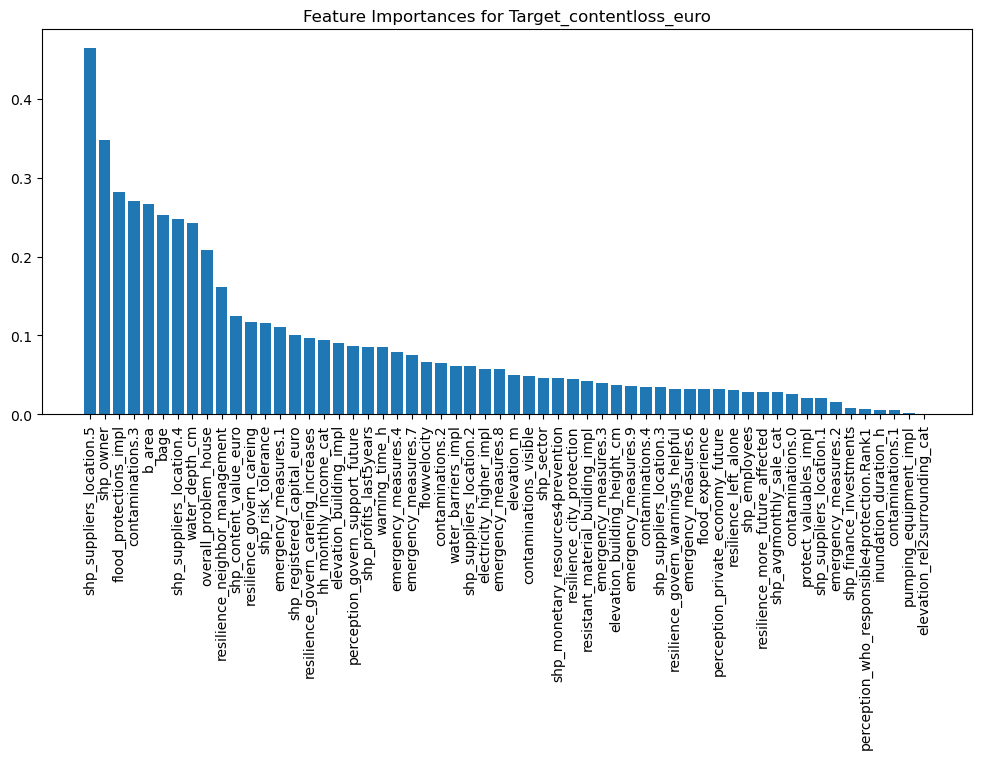

In [87]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12,5))

## coef of feature importances
df_importance = pd.DataFrame({
    "name" : X_unscaled.columns.to_list(),
    "importances" : np.absolute(elastic_net.coef_),
     }) 

# drop features which dont reduce the loss
df_importance = df_importance.loc[df_importance.importances > 0.0, : ] 
df_importance = df_importance.sort_values("importances", ascending=False)

plt.bar(df_importance.name, df_importance.importances)
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

In [54]:
# coef = pd.Series(elastic_net.coef_, index = X_train.columns)
# important_features = pd.concat([coef.sort_values().head(10),
#                      coef.sort_values().tail(10)])
# important_features.plot(kind = "barh")
# plt.title("Coefficients in the ElasticNet Model")